# Evaluation
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('data-week-3.csv')
 
df.columns = df.columns.str.lower().str.replace(' ', '_')
 
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
 
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
 
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
 
df.churn = (df.churn == 'yes').astype(int)

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
 
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values
 
del df_train['churn']
del df_val['churn']
del df_test['churn'] 

In [4]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
 
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [5]:
dv = DictVectorizer(sparse=False)
 
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
 
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [6]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
 
y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

# Accuracy and Dummy model

In [7]:
len(y_val)

1409

In [8]:
(y_val == churn_decision).sum()

np.int64(1129)

In [9]:
1132 / 1409

0.8034066713981547

In [10]:
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

In [11]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [12]:
scores = []
 
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.598
0.15 0.664
0.20 0.707
0.25 0.737
0.30 0.759
0.35 0.766
0.40 0.780
0.45 0.793
0.50 0.801
0.55 0.798
0.60 0.797
0.65 0.784
0.70 0.765
0.75 0.744
0.80 0.730
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


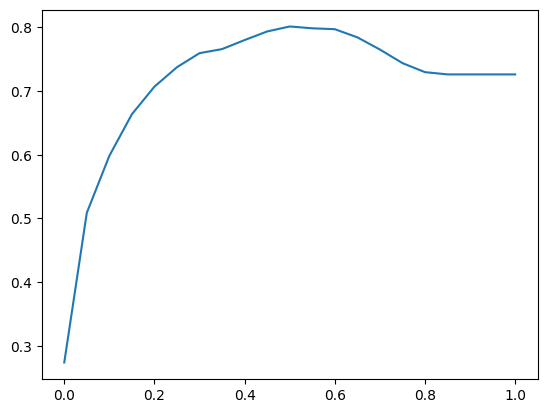

In [13]:
plt.plot(thresholds,scores)

In [14]:
# from sklearn.metrics import accuracy_score
 
# thresholds = np.linspace(0, 1, 21)
# scores = []
 
# for t in thresholds:
#     score = accuracy_score(y_val, y_pred >= t)
#     print('%.2f %.3f' % (t, score))
#     scores.append(score)

In [15]:
from collections import Counter

In [16]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [17]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [18]:
1023 / 1409 #or 1-y_val.mean()

0.7260468417317246

This shows class imbalance and that we can't rely only on accuracy

# Confusion Table

In [19]:
# people who are going to churn
actual_positive = (y_val == 1)
# people who are not going to churn
actual_negative = (y_val == 0)

In [20]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [21]:
tp = (predict_positive & actual_positive).sum()
tp

np.int64(214)

In [22]:
tn = (predict_negative & actual_negative).sum()
tn

np.int64(915)

In [23]:
fp = (predict_positive & actual_negative).sum()
fp

np.int64(108)

In [24]:
fn = (predict_negative & actual_positive).sum()
fn

np.int64(172)

In [25]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
 
confusion_matrix

array([[915, 108],
       [172, 214]])

In [26]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.08],
       [0.12, 0.15]])

# Precision and Recall

Precision measures the fraction of positive predictions that were correct. In other words, it quantifies how accurately the model predicts customers who are likely to churn.

Recall, on the other hand, quantifies the fraction of actual positive cases that were correctly identified by the model. It assesses how effectively the model captures all customers who are actually churning.

In [27]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

np.float64(0.801277501774308)

In [28]:
precision = tp / (tp + fp)
precision

np.float64(0.6645962732919255)

In [29]:
# --> promotional email goes to 311 people, but 210 are actually going to churn (--> 33% are mistakes)
tp + fp

np.int64(322)

In [30]:
recall = tp / (tp + fn)
recall

np.float64(0.5544041450777202)

In [31]:
# --> For 46% of people who are churning we failed to identify them
tp + fn

np.int64(386)

# ROC Curve

In [32]:
tpr = tp / (tp + fn)
tpr # Same as recall

np.float64(0.5544041450777202)

In [33]:
fpr = fp / (fp + tn)
fpr

np.float64(0.10557184750733138)

In [34]:
scores = []
thresholds = np.linspace(0, 1, 101)
 
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
 
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
 
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
 
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
 
    scores.append((t, tp, tn, fp, fn))
 
scores

[(np.float64(0.0), np.int64(386), np.int64(0), np.int64(1023), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(120), np.int64(903), np.int64(1)),
 (np.float64(0.02), np.int64(384), np.int64(211), np.int64(812), np.int64(2)),
 (np.float64(0.03), np.int64(382), np.int64(270), np.int64(753), np.int64(4)),
 (np.float64(0.04), np.int64(380), np.int64(315), np.int64(708), np.int64(6)),
 (np.float64(0.05), np.int64(378), np.int64(339), np.int64(684), np.int64(8)),
 (np.float64(0.06), np.int64(376), np.int64(363), np.int64(660), np.int64(10)),
 (np.float64(0.07), np.int64(374), np.int64(392), np.int64(631), np.int64(12)),
 (np.float64(0.08), np.int64(371), np.int64(422), np.int64(601), np.int64(15)),
 (np.float64(0.09), np.int64(369), np.int64(454), np.int64(569), np.int64(17)),
 (np.float64(0.1), np.int64(367), np.int64(476), np.int64(547), np.int64(19)),
 (np.float64(0.11), np.int64(365), np.int64(503), np.int64(520), np.int64(21)),
 (np.float64(0.12), np.int64(363), np.int64(520),

In [35]:
columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,tn,fp,fn
0,0.00,386,0,1023,0
1,0.01,385,120,903,1
2,0.02,384,211,812,2
3,0.03,382,270,753,4
4,0.04,380,315,708,6
...,...,...,...,...,...
96,0.96,0,1023,0,386
97,0.97,0,1023,0,386
98,0.98,0,1023,0,386
99,0.99,0,1023,0,386


In [36]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,367,476,547,19,0.950777,0.534702
20,0.2,334,662,361,52,0.865285,0.352884
30,0.3,291,779,244,95,0.753886,0.238514
40,0.4,253,846,177,133,0.655440,0.173021
50,0.5,214,915,108,172,0.554404,0.105572
60,0.6,153,970,53,233,0.396373,0.051808
70,0.7,69,1009,14,317,0.178756,0.013685
80,0.8,5,1023,0,381,0.012953,0.000000
90,0.9,0,1023,0,386,0.000000,0.000000


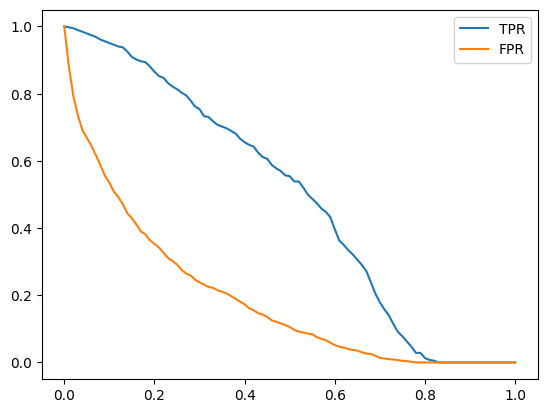

In [37]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

## Random Model

In [38]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089], shape=(1409,))

In [39]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [40]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
 
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
 
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
 
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
 
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
 
        scores.append((t, tp, tn, fp, fn))
 
    columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
    df_scores = pd.DataFrame(scores, columns=columns)
 
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
 
    return df_scores

In [41]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


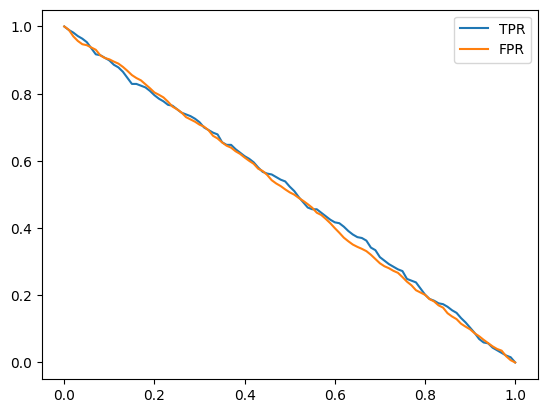

In [42]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

## Ideal Model

In [43]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [44]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [45]:
y_ideal_pred = np.linspace(0, 1, len(y_ideal))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00], shape=(1409,))

In [46]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [47]:
accuracy_ideal = ((y_ideal_pred >= 0.726) == y_ideal).mean()
accuracy_ideal

np.float64(1.0)

In [48]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,386,141,882,0,1.000000,0.862170
20,0.2,386,282,741,0,1.000000,0.724340
30,0.3,386,423,600,0,1.000000,0.586510
40,0.4,386,564,459,0,1.000000,0.448680
50,0.5,386,704,319,0,1.000000,0.311828
60,0.6,386,845,178,0,1.000000,0.173998
70,0.7,386,986,37,0,1.000000,0.036168
80,0.8,282,1023,0,104,0.730570,0.000000
90,0.9,141,1023,0,245,0.365285,0.000000


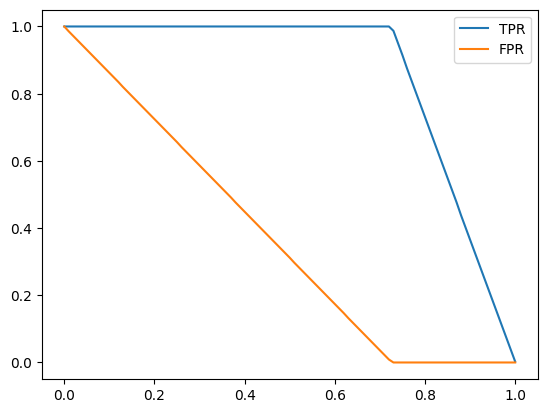

In [49]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

## Putting everything together

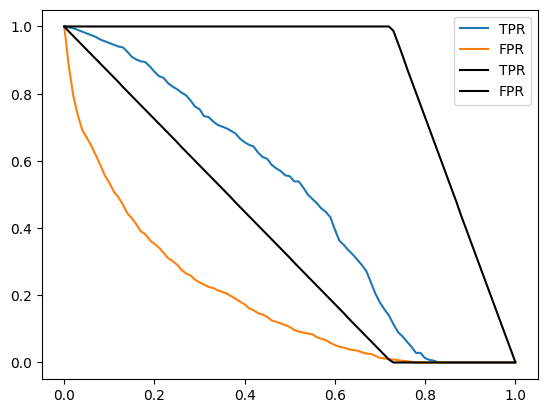

In [50]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
 
#plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
#plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
 
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color = 'black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color = 'black')
 
plt.legend()

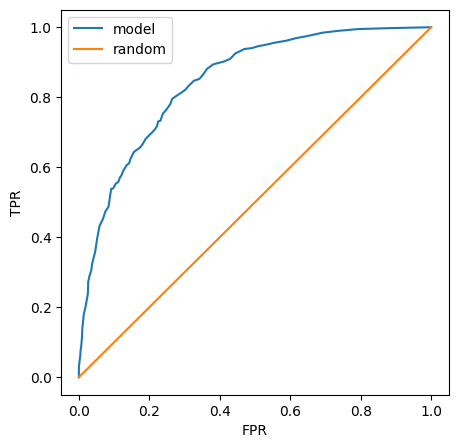

In [51]:
plt.figure(figsize=(5,5))
 
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

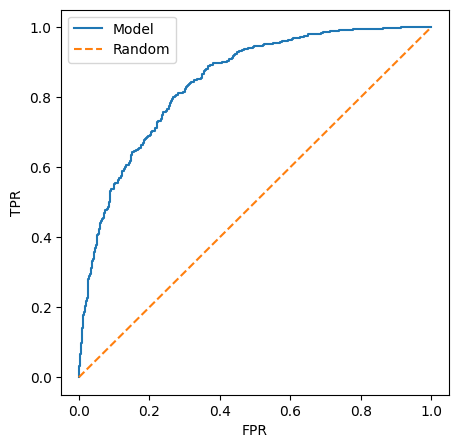

In [52]:
# We can also use the ROC functionality of scikit learn package
from sklearn.metrics import roc_curve
 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
 
plt.figure(figsize=(5,5))
 
plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle='--')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

# ROC AUC

AUC equals 0.5 for a random baseline and 1.0 for an ideal curve. Therefore, our model’s AUC should fall between 0.5 and 1.0. When AUC is less than 0.5, we’ve made a mistake. AUC = 0.8 is considered good, while 0.9 is great.

In [53]:
from sklearn.metrics import auc
# auc needs values for x-axis and y-axis
auc(fpr, tpr)

0.8445038720820102

In [54]:
auc(df_scores.fpr, df_scores.tpr)

0.8443696534119398

In [55]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [56]:
# to calc roc auc 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8445038720820102

In [57]:
#or
from sklearn.metrics import roc_auc_score
 
roc_auc_score(y_val, y_pred)

0.8445038720820102

# AUC Interpretation

In [60]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [61]:
import random
n = 100000
success = 0
 
for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)
 
    if pos[pos_ind] > neg[neg_ind]:
        success += 1
 
success / n

0.8446

In [62]:
#or using numpy
n = 50000
 
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8466)

# Cross Validation

In [65]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
 
    return dv, model

In [66]:
dv, model = train(df_train, y_train)

In [67]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [68]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.0066238 , 0.20482253, 0.21781799, ..., 0.15149644, 0.78847856,
       0.81190391], shape=(1409,))

We now have the ‘train’ and ‘predict’ functions in place. Let’s proceed to implement K-Fold Cross-Validation.

In [69]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1) 
 
kfold.split(df_full_train)

<generator object _BaseKFold.split at 0x796164754d00>

In [70]:
train_idx, val_idx = next(kfold.split(df_full_train))
len(train_idx), len(val_idx)

(5070, 564)

In [71]:
len(df_full_train)

5634

In [72]:
# We can use iloc to select a part of this dataframe
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [74]:
#for 10 folds
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
 
scores

[0.8496891051635577,
 0.8423576732673268,
 0.8582960982010862,
 0.8332236029956382,
 0.8248604218362282,
 0.8410922410922411,
 0.8431129925105829,
 0.8252609108159393,
 0.8458425967096488,
 0.8609794628751974]

In [77]:
#same implementation but with tqdm package
from sklearn.model_selection import KFold
!pip3 install tqdm
from tqdm.auto import tqdm
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
 
scores

10it [00:09,  1.05it/s]


[0.8496891051635577,
 0.8423576732673268,
 0.8582960982010862,
 0.8332236029956382,
 0.8248604218362282,
 0.8410922410922411,
 0.8431129925105829,
 0.8252609108159393,
 0.8458425967096488,
 0.8609794628751974]

In [78]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.842 +- 0.012


## Parameter Tuning

In [82]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)
 
    return dv, model

In [83]:
dv, model = train(df_train, y_train, C=0.001)

In [84]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
 
for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
     
    scores = []
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.churn.values
        y_val = df_val.churn.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
 

C=0.001 0.826 +- 0.012
C=0.01 0.841 +- 0.012
C=0.1 0.842 +- 0.012
C=0.5 0.843 +- 0.012
C=1 0.842 +- 0.012
C=5 0.842 +- 0.012
C=10 0.842 +- 0.012


In [85]:
from sklearn.model_selection import KFold
 
n_splits = 5
 
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):   
    scores = []
 
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)  
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.churn.values
        y_val = df_val.churn.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
 

 14%|██████████████████████▍                                                                                                                                      | 1/7 [00:01<00:08,  1.41s/it]

C=0.001 0.825 +- 0.009


 29%|████████████████████████████████████████████▊                                                                                                                | 2/7 [00:04<00:12,  2.60s/it]

C=0.01 0.840 +- 0.008


 43%|███████████████████████████████████████████████████████████████████▎                                                                                         | 3/7 [00:11<00:17,  4.48s/it]

C=0.1 0.842 +- 0.007


 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 4/7 [00:16<00:13,  4.55s/it]

C=0.5 0.842 +- 0.007


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 5/7 [00:20<00:09,  4.63s/it]

C=1 0.842 +- 0.007


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6/7 [00:25<00:04,  4.64s/it]

C=5 0.842 +- 0.007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:30<00:00,  4.34s/it]

C=10 0.842 +- 0.007


In [86]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
 
auc = roc_auc_score(y_test, y_pred)
auc

0.8584032088573997